In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from model import resnet34, resnet50, resnet101
from data_loader import get_train_loader

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_loader, validate_loader = get_train_loader()

cuda:0
---------------------------- D:\VScode\Code\VScode程序\俱乐部小作业\ResNet\data_set\flowers ----------------------------


In [19]:
len(validate_loader), len(validate_loader.dataset)

(55, 865)

In [20]:
# 加载预处理好的模型参数
# # load pretrain weights
# # download url: https://download.pytorch.org/models/resnet34-333f7ec4.pth
# model_weight_path = "./resnet34-pre.pth"    # 保存权重的路径
# missing_keys, unexpected_keys = net.load_state_dict(
#     torch.load(model_weight_path, map_location='cpu'))  # torch.load载入模型权重到内存中（还没有载入到模型中）
# # for param in net.parameters():
# #     param.requires_grad = False
# # change fc layer structure
# in_channel = net.fc.in_features    # 输入特征矩阵的深度
# net.fc = nn.Linear(in_channel, 5)  # 五分类（花分类数据集）

In [21]:
# 可视化训练过程中的损失和准确率
def visualize_performance(train_loss, val_loss, val_acc, name):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('./visual_result/' + name + '.png')
    plt.show()


In [22]:
# 构造模型
def model(net, name, loss_function, train_loader, validate_loader, save_path, num_epochs = 5):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    net.to(device)             #实例化，这里没有传入参数num_classes，即实例化后的最后一个全连接层有1000个节点

    best_acc = 0.0   
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    # construct an optimizer
    optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay = 1e-4)

    # optimizer = optim.SGD(
    #     net.parameters(),
    #     lr=0.1,
    #     momentum=0.9,
    #     weight_decay=1e-4
    # )
    # 添加学习率调度
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    for epoch in range(num_epochs):
        # train

        net.train()
        running_loss = 0.0
        for step, data in enumerate(train_loader, start=0):
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = net(images)
            loss = loss_function(logits, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print train process
            rate = (step + 1) / len(train_loader)
            a = "*" * int(rate * 50)
            b = "." * int((1 - rate) * 50)
            print("\rtrain loss:{:^3.0f}%[{}—>{}]{:.4f}".format(int(rate * 100), a, b, loss), end="")
        epoch_train_loss = running_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)
        print()
        scheduler.step()  # 更新学习率(学习率调度)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        val_loss = 0.0
        with torch.no_grad():
            for val_data in validate_loader:
                test_images, test_labels = val_data
                test_images, test_labels = test_images.to(device), test_labels.to(device)
                outputs = net(test_images)
                loss = loss_function(outputs, test_labels)

                val_loss += loss.item()

                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, test_labels).sum().item()

                validate_loader.desc = "valid epoch[{}/{}]".format(epoch + 1, 3)
        epoch_val_loss = val_loss / len(validate_loader)
        val_loss_history.append(epoch_val_loss)
        val_accurate = acc / len(validate_loader.dataset)
        val_acc_history.append(val_accurate)
        print('[epoch %d] train_loss: %.3f  val_loss: %.3f val_accuracy: %.3f' %
            (epoch + 1, epoch_train_loss, epoch_val_loss, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')

    # 训练结束后调用
    visualize_performance(train_loss_history, val_loss_history, val_acc_history, name)

In [23]:
# train the model
# define loss function
loss_function = nn.CrossEntropyLoss()

save_path = './weight_outcome'

train loss:100%[**************************************************—>]1.6307
[epoch 1] train_loss: 1.456  val_loss: 1.272 val_accuracy: 0.479
train loss:100%[**************************************************—>]1.3975
[epoch 2] train_loss: 1.326  val_loss: 1.363 val_accuracy: 0.403
train loss:100%[**************************************************—>]1.3126
[epoch 3] train_loss: 1.279  val_loss: 1.207 val_accuracy: 0.527
train loss:100%[**************************************************—>]1.7152
[epoch 4] train_loss: 1.216  val_loss: 1.233 val_accuracy: 0.490
train loss:100%[**************************************************—>]0.9456
[epoch 5] train_loss: 1.179  val_loss: 1.069 val_accuracy: 0.565
train loss:100%[**************************************************—>]1.1037
[epoch 6] train_loss: 1.074  val_loss: 1.074 val_accuracy: 0.607
train loss:100%[**************************************************—>]0.9448
[epoch 7] train_loss: 1.050  val_loss: 0.991 val_accuracy: 0.643
train loss:10

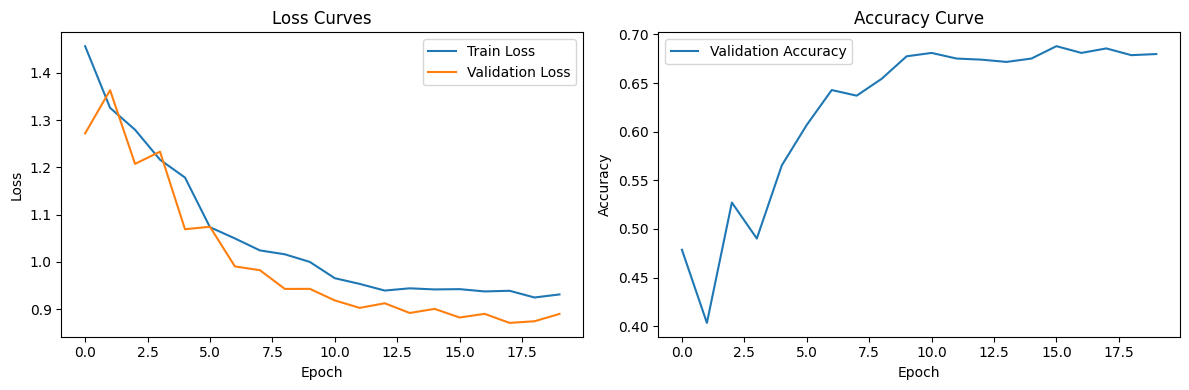

In [24]:
net1 = resnet34()
model(net1, 'Resnet34', loss_function , train_loader, validate_loader, save_path = save_path + '/ResNet34.pth', num_epochs = 20)

train loss:100%[**************************************************—>]1.4618
[epoch 1] train_loss: 1.548  val_loss: 1.391 val_accuracy: 0.437
train loss:100%[**************************************************—>]1.2711
[epoch 2] train_loss: 1.342  val_loss: 1.403 val_accuracy: 0.488
train loss:100%[**************************************************—>]1.1296
[epoch 3] train_loss: 1.281  val_loss: 1.891 val_accuracy: 0.502
train loss:100%[**************************************************—>]0.9544
[epoch 4] train_loss: 1.238  val_loss: 3.856 val_accuracy: 0.437
train loss:100%[**************************************************—>]0.8186
[epoch 5] train_loss: 1.188  val_loss: 1.074 val_accuracy: 0.595
train loss:100%[**************************************************—>]0.6000
[epoch 6] train_loss: 1.071  val_loss: 0.936 val_accuracy: 0.657
train loss:100%[**************************************************—>]0.7571
[epoch 7] train_loss: 1.007  val_loss: 0.896 val_accuracy: 0.669
train loss:10

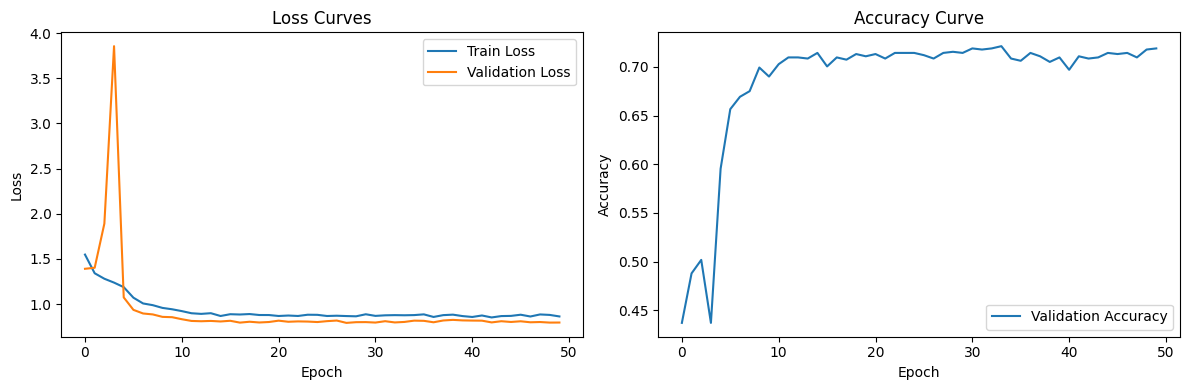

In [25]:
net2 = resnet50()
model(net2, 'Resnet50', loss_function, train_loader, validate_loader, save_path = save_path + '/ResNet50.pth', num_epochs = 50)

train loss:100%[**************************************************—>]1.3461
[epoch 1] train_loss: 1.603  val_loss: 15.061 val_accuracy: 0.394
train loss:100%[**************************************************—>]1.3404
[epoch 2] train_loss: 1.359  val_loss: 1.389 val_accuracy: 0.421
train loss:100%[**************************************************—>]1.1403
[epoch 3] train_loss: 1.337  val_loss: 1.525 val_accuracy: 0.436
train loss:100%[**************************************************—>]1.4757
[epoch 4] train_loss: 1.275  val_loss: 1.209 val_accuracy: 0.495
train loss:100%[**************************************************—>]1.3415
[epoch 5] train_loss: 1.235  val_loss: 1.226 val_accuracy: 0.519
train loss:100%[**************************************************—>]0.8363
[epoch 6] train_loss: 1.122  val_loss: 1.042 val_accuracy: 0.605
train loss:100%[**************************************************—>]1.4886
[epoch 7] train_loss: 1.091  val_loss: 1.019 val_accuracy: 0.605
train loss:1

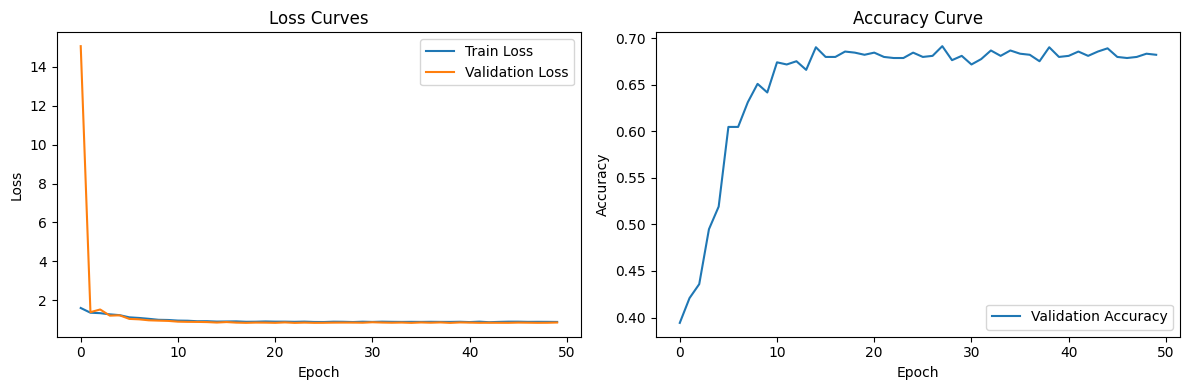

In [26]:
net3 = resnet101()
model(net3, 'Resnet101', loss_function, train_loader, validate_loader, save_path = save_path + '/ResNet101.pth', num_epochs = 50)